In [1]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense, Masking
import matplotlib.pyplot as plt

In [2]:

def extract_chroma_features(file_path,sr=8000):
    y, sr = librosa.load(file_path, sr=None)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    return chroma.T  # Transpose to have time axis first

def load_dataset(directory,sr=8000):
    features = []
    labels = []
    filenames = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(subdir, file)
                chroma_features = extract_chroma_features(file_path)
                features.append(chroma_features)
                labels.append(os.path.basename(subdir))  # Assuming subdirectory names are labels
                filenames.append(file_path)
    return features, labels, filenames

In [3]:
# Load dataset
features, labels, filenames = load_dataset(r"C:\Users\Sachin\Desktop\ai_projects\Alexa\dataset_alexa")

# Print the shape of extracted features
print(f"Number of samples: {len(features)}")
print(f"Shape of first sample's features: {features[10].shape}")


Number of samples: 198
Shape of first sample's features: (17, 12)


In [4]:
# Encode labels to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Pad sequences to the same length
max_sequence_length = max([len(f) for f in features])
padded_features = pad_sequences(features, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
encoded_labels = np.eye(num_classes)[encoded_labels]

In [5]:
# Print shapes after preprocessing
print(f"Padded features shape: {padded_features.shape}")
print(f"Encoded labels shape: {encoded_labels.shape}")

Padded features shape: (198, 17, 12)
Encoded labels shape: (198, 2)


In [6]:

# Build the GRU model
gru_model = Sequential()
gru_model.add(Masking(mask_value=0., input_shape=(max_sequence_length, 12)))  # 12 chroma features
gru_model.add(GRU(64, return_sequences=False))
gru_model.add(Dense(num_classes, activation='softmax'))
gru_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 17, 12)            0         
_________________________________________________________________
gru (GRU)                    (None, 64)                14784     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 14,914
Trainable params: 14,914
Non-trainable params: 0
_________________________________________________________________


In [7]:
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [8]:
# Train the GRU model
gru_model.fit(padded_features, encoded_labels, epochs=20, batch_size=32, validation_split=0.2)

Train on 158 samples, validate on 40 samples
Epoch 1/20
158/158 [==============================] - ETA: 1s - loss: 0.6788 - acc: 0.562 - 0s 3ms/sample - loss: 0.6806 - acc: 0.5696 - val_loss: 0.8929 - val_acc: 0.1500
Epoch 2/20
158/158 [==============================] - ETA: 0s - loss: 0.6907 - acc: 0.500 - 0s 354us/sample - loss: 0.6562 - acc: 0.6139 - val_loss: 0.8189 - val_acc: 0.3000
Epoch 3/20
158/158 [==============================] - ETA: 0s - loss: 0.6287 - acc: 0.656 - 0s 349us/sample - loss: 0.6363 - acc: 0.6709 - val_loss: 0.8353 - val_acc: 0.3000
Epoch 4/20
158/158 [==============================] - ETA: 0s - loss: 0.6168 - acc: 0.718 - 0s 373us/sample - loss: 0.6148 - acc: 0.6899 - val_loss: 0.8614 - val_acc: 0.3000
Epoch 5/20
158/158 [==============================] - ETA: 0s - loss: 0.6140 - acc: 0.718 - 0s 352us/sample - loss: 0.5974 - acc: 0.7215 - val_loss: 0.8382 - val_acc: 0.3000
Epoch 6/20
158/158 [==============================] - ETA: 0s - loss: 0.5558 - acc: 0.7

In [9]:

# Evaluate the GRU model
gru_loss, gru_accuracy = gru_model.evaluate(padded_features, encoded_labels)
print(f'GRU Model - Loss: {gru_loss}, Accuracy: {gru_accuracy}')

# Save the GRU model
# gru_model.save('gru_chroma_model.h5')

198/198 [==============================] - ETA: 0s - loss: 0.0589 - acc: 1.000 - 0s 104us/sample - loss: 0.0361 - acc: 1.0000
GRU Model - Loss: 0.036077033709546534, Accuracy: 1.0


In [10]:
# Generate predictions and plot confusion matrix for GRU model
gru_y_pred = gru_model.predict(padded_features)
gru_y_pred_classes = np.argmax(gru_y_pred, axis=1)
gru_y_true_classes = np.argmax(encoded_labels, axis=1)


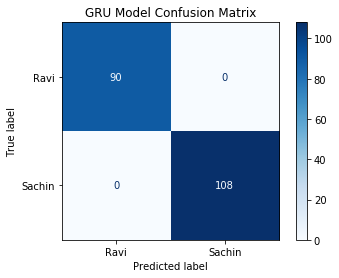

In [11]:
gru_cm = confusion_matrix(gru_y_true_classes, gru_y_pred_classes)
gru_disp = ConfusionMatrixDisplay(confusion_matrix=gru_cm, display_labels=label_encoder.classes_)
gru_disp.plot(cmap=plt.cm.Blues)
plt.title('GRU Model Confusion Matrix')
plt.show()

In [12]:
# Print filenames of incorrectly predicted samples for GRU model
gru_incorrect_indices = np.where(gru_y_pred_classes != gru_y_true_classes)[0]
print("GRU Model - Incorrectly predicted files:")
for index in gru_incorrect_indices:
    print(filenames[index])


GRU Model - Incorrectly predicted files:


In [13]:
# Load the trained GRU model for prediction
gru_model = load_model('gru_chroma_model.h5')

def predict_gru(file_path):
    # Extract chroma features
    chroma_features = extract_chroma_features(file_path)
    chroma_features = chroma_features[np.newaxis, ...]  # Add batch dimension

    # Pad sequence to the same length
    padded_features = pad_sequences(chroma_features, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

    # Make prediction
    prediction = gru_model.predict(padded_features)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_label = label_encoder.inverse_transform(predicted_class)
    
    return predicted_label[0]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
# Test the GRU prediction function
test_file_path = r"C:\Users\Sachin\Desktop\ai_projects\Alexa\dataset_alexa\Ravi\Ravi_alexa (mp3cut.net) (4)_1.wav"  # Replace with the path to your test WAV file
predicted_label_gru = predict_gru(test_file_path)
print(f'GRU Model - Predicted label for the test file: {predicted_label_gru}')


GRU Model - Predicted label for the test file: Ravi
